In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import random
import seaborn as sns
from pathlib import Path
from scipy.interpolate import make_interp_spline
from collections import deque

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

sys.path.append("hawkeslib-master/")

from hawkeslib import MultivariateExpHawkesProcess as MVH


if not hasattr(np, "float"):
    np.float = float
if not hasattr(np, "int"):
    np.int = int
if not hasattr(np, "bool"):
    np.bool = bool


import warnings
warnings.simplefilter("ignore", category=UserWarning)


# Multivariate Hawkes Testing

In [ ]:

multi_fit = MVH()
multi_test = MVH()


mu_true    = np.array([0.01, 0.01])
A_true     = np.array([[0.20, 0.40],   # from type 0 to (0,1)
                       [0.10, 0.15]])  # from type 1 to (0,1)
theta_true = 2.0
T = 1e5
multi_test.set_params(mu = mu_true, A=  A_true , theta = theta_true)

sample = multi_test.sample(100000)
t=  sample[0]
c= sample[1]

multi_fit.fit(t = t, c= c, T = t[-1]+1)
multi_fit.get_params()

# Event structure exploration

## Methods

In [ ]:
def get_states(num_states, theta, t_val, c_val): 
    state_machine = np.zeros((num_states,num_states, len(t_val) + 1))
    for t_idx, event in enumerate(c_val):
        if t_idx != 0: 
            t_cur = t_val[t_idx]
            inter_state_decay = np.exp(-theta * (t_cur - t_val[t_idx-1])) 

            state_machine[:,:,t_idx] = inter_state_decay * state_machine[:,:,t_idx-1]
            state_machine[:, event, t_idx] += 1 
    
    return state_machine[:, :, 1:]

def get_lambda(params, t_val, c_val):
    mu_base = params[0]
    alpha = params[1]
    theta = params[2]
    num_states = len(mu_base)

    states = get_states(num_states, theta, t_val, c_val)

    lam_vec = np.zeros((num_states, len(t_val)))
    for self.state_idx in range(num_states):
        lam_vec[self.state_idx, :] = np.sum(alpha[self.state_idx, :].reshape(-1,1) * states[self.state_idx, :, :], axis =0) * theta + mu_base[self.state_idx]
    
    return lam_vec

def get_residuals(t_val, lam_vec):
    # One residual per inter-event interval
    res = np.zeros(len(t_val) - 1)
    for n in range(len(res)):
        res[n] = np.trapezoid(
            y=[lam_vec[n], lam_vec[n+1]],
            x=[t_val[n], t_val[n+1]]
        )
    return res


def get_all_residuals(t_val, lam):
    num_states = lam.shape[0]
    res_vec=  np.zeros(num_states)
    for i in range(num_states):
        res =  np.trapezoid(y=[lam[i, :-1], lam[i, 1:]], x=[t_val[:-1], t_val[1:]], axis=0)
        res_vec[i] = 1- np.exp(-res) # time rescaling theorem
        print(f"State {i} Residuals: min {res_vec.min()}, max {res_vec.max()}, mean {res_vec.mean()}")
    
    return res_vec

def BBO_1_preproccess(path): 
    df = pd.read_csv(path, compression='zstd')
    df = df.dropna(axis=0)

    df.drop(['bid_ct_00', 'ask_ct_00', 'ts_event', 
            'publisher_id', 'instrument_id', 
            'rtype', 'flags', 'symbol', 'sequence'], axis =1, inplace=True) 

    df['ts_recv'] =pd.to_datetime(df['ts_recv'], utc=True)
    df['ts_recv'] = df['ts_recv'].dt.tz_convert('US/Eastern')
    
    # Remove any trading before hours 
    df = df[df['ts_recv'].dt.hour > 8]

    df = df[100::] # Remove some noise in the first transcations 

    temp_df = (
        df.add_suffix('_curr')
        .join(df.shift(1).add_suffix('_prev'))
        )
    # no_change = (tem_['bid_px_00_curr'] == tem_['bid_px_00_prev']) & (tem_['ask_px_00_curr'] == tem_['ask_px_00_prev'])

    temp_df['mid_curr'] = (temp_df['bid_px_00_curr'] + temp_df['ask_px_00_curr']) / 2
    temp_df['mid_prev'] = (temp_df['bid_px_00_prev'] + temp_df['ask_px_00_prev']) / 2

    temp_df.loc[temp_df['mid_curr']  > temp_df['mid_prev']  , 'state'] = 'MU'
    temp_df.loc[temp_df['mid_curr']  < temp_df['mid_prev']  , 'state'] = 'MD'

    temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['ask_sz_00_curr'] < temp_df['ask_sz_00_prev']) , 'state'] = "ADNM"
    temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['ask_sz_00_curr'] > temp_df['ask_sz_00_prev']) , 'state'] = "AUNM"
    temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['bid_sz_00_curr'] < temp_df['bid_sz_00_prev']) , 'state'] = "BDNM"
    temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['bid_sz_00_curr'] > temp_df['bid_sz_00_prev']) , 'state'] = "BUNM"

    temp_df.loc[temp_df['state'].isna(), 'state'] = "IDLE"

    states_df = temp_df.loc[1:len(temp_df), ['ts_recv_curr', 'state', 'mid_curr']].copy()
    states_df['time_s'] = (states_df['ts_recv_curr'] - states_df['ts_recv_curr'].iloc[0]).dt.total_seconds() 
    states_df.reset_index(drop=True, inplace=True)

    return states_df, df 

def params_to_entry(params): 
    mu_base = params[0]
    alpha = params[1]
    theta = params[2]

    record = {f"{i}{j}": alpha[i, j] 
                for i in range(alpha.shape[0]) 
                for j in range(alpha.shape[1])}

    for i in range(len(mu_base)): record['mu_' + str(i)] = mu_base[i]
    record['theta'] = theta 
    return record

def get_compensator_increments(mu, A, t_val, state_machine):
    """
    Compute ΔΛ_i(T_{n+1}, T_n) for each process i using pre-event states.

    Parameters
    ----------
    mu : (K,) array
        Base intensities λ_i.
    A : (K,K) array
        Infectivity matrix α_ij.
    t_val : (N,) array
        Event times (sorted, same length as state_machine[0,0,:]).
    state_machine : (K,K,N) array
        States S_ij(t) evaluated *just before* each event time (from get_states).

    Returns
    -------
    dLambda : (K, N-1) array
        Compensator increments ΔΛ_i(T_{n+1}, T_n)
        for each i over each inter-event interval.
    """
    mu = np.asarray(mu, float)
    A = np.asarray(A, float)
    K = mu.shape[0]
    N = len(t_val)

    dLambda = np.zeros((K, N - 1))
    delta_t = np.diff(t_val)

    for n in range(N - 1):
        # pre- and post-event states
        S_pre = state_machine[:, :, n]          # S(T_n^-)
        S_post = state_machine[:, :, n + 1]     # S(T_{n+1}^-)

        # 1 + S_ij(T_n^-) - S_ij(T_{n+1}^-)
        delta_S = 1.0 + S_pre - S_post

        base_term = mu * delta_t[n]
        excite_term = (A * delta_S).sum(axis=1)

        dLambda[:, n] = base_term + excite_term

    return dLambda


## MBP-1

In [2]:
df = pd.read_csv("dataset/AAPL_1_MONTH/equs-mini-20251001.mbp-1.csv.zst", compression='zstd')
df = df.dropna(axis=0)

df = df[df['side'] != 'N']
df= df[~df['action'].isin(['N', 'T', 'R'])]
df.drop(['bid_ct_00', 'ask_ct_00', 'ts_in_delta', 
         'sequence', 'symbol', 'publisher_id', 'instrument_id', 
         'ts_event', 'rtype', 'depth', 'flags'], axis =1, inplace=True) 
df['ts_recv'] =pd.to_datetime(df['ts_recv'], utc=True)
df['ts_recv'] = df['ts_recv'].dt.tz_convert('US/Eastern')

df_mid_hours = df[(df['ts_recv'].dt.hour > 9)  & (df['ts_recv'].dt.hour < 15)]
df_mid_hours = df_mid_hours.reset_index(drop=True)


Event structure 
1. MU: Midpoint up 
2. MD: Midpoint down 
3. ADNM: Ask size decreases, price stays the same
4. BDNM: bid size decrease, price stays the same
5. AUNM: Ask size increases, price stays the same
6. BUNM: Bid size increases, no movement 



In [ ]:
temp_df = (
    df_mid_hours.add_suffix('_curr')
    .join(df_mid_hours.shift(1).add_suffix('_prev'))
)
# no_change = (tem_['bid_px_00_curr'] == tem_['bid_px_00_prev']) & (tem_['ask_px_00_curr'] == tem_['ask_px_00_prev'])

temp_df['mid_curr'] = (temp_df['bid_px_00_curr'] + temp_df['ask_px_00_curr']) / 2
temp_df['mid_prev'] = (temp_df['bid_px_00_prev'] + temp_df['ask_px_00_prev']) / 2

temp_df.loc[temp_df['mid_curr']  > temp_df['mid_prev']  , 'state'] = 'MU'
temp_df.loc[temp_df['mid_curr']  < temp_df['mid_prev']  , 'state'] = 'MD'

temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['ask_sz_00_curr'] < temp_df['ask_sz_00_prev']) , 'state'] = "ADNM"
temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['ask_sz_00_curr'] > temp_df['ask_sz_00_prev']) , 'state'] = "AUNM"
temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['bid_sz_00_curr'] < temp_df['bid_sz_00_prev']) , 'state'] = "BDNM"
temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['bid_sz_00_curr'] > temp_df['bid_sz_00_prev']) , 'state'] = "BUNM"

temp_df.loc[temp_df['state'].isna(), 'state'] = "IDLE"

states_df = temp_df.loc[1:len(temp_df), ['ts_recv_curr', 'state']].copy()

states_df = temp_df.loc[1:len(temp_df), ['ts_recv_curr', 'state']].copy()
states_df['ts_recv_curr'] = (states_df['ts_recv_curr'] - states_df['ts_recv_curr'][1]).dt.total_seconds() 
states_df.reset_index(drop=True, inplace=True)


In [ ]:
states_df_simp = states_df[~states_df['state'].isin(['AUNM', 'BUNM'])].reset_index(drop=True)
states_sample = states_df_simp.loc[300:1e4, :]

In [29]:
t_val =  states_sample['ts_recv_curr'].to_numpy() 
c_val =  states_sample['state'].map({'MU':0, 'MD':1, 'ADNM':2, 'BDNM':3}).to_numpy()

In [39]:
from hawkeslib import MultivariateExpHawkesProcess as MVH


multi_fit = MVH()
multi_fit.fit(t = t_val, c=c_val, T = t_val[-1] + 1)


KeyboardInterrupt: 

## BBO- 1s

In [137]:
states_df, df = BBO_1_preproccess("dataset/AAPL_BBO_1s/equs-mini-20251006.bbo-1s.csv.zst")

### Per day variation - 1 

In [ ]:
states_to_keep = ['MU', 'MD']
states_slice = states_df[ states_df['state'].isin(states_to_keep)].reset_index(drop=True)
state_map = {j : i for i,j in enumerate(states_to_keep)}
t_val =  states_slice['ts_recv_curr'].to_numpy() 
c_val =  states_slice['state'].map(state_map).to_numpy()

In [ ]:
n_splits = 4
t_split = np.array_split(t_val, n_splits)
c_split = np.array_split(c_val, n_splits)

results = pd.DataFrame(columns= ['mu_MU', 'mu_MD', 
                      'a_MU_MU', 'a_MU_MD', 'a_MD_MU', 'a_MD_MD',
                      'theta'])

for i in range(n_splits):
    multi_fit = MVH()
    t_temp = t_split[i] - t_split[i][0]
    c_temp  =c_split[i]

    multi_fit.fit(t = t_temp, c=c_split[i], T = t_temp[-1] + 1)
    param_val = multi_fit.get_params()
    results.loc[i] = np.hstack([param_val[0], param_val[1].ravel(), param_val[2]])

In [166]:
results

,mu_MU,mu_MD,a_MU_MU,a_MU_MD,a_MD_MU,a_MD_MD,theta
0,0.271127,0.207027,0.105285,0.184799,0.183774,0.220595,0.012627
1,0.214882,0.148823,0.161107,0.203933,0.103527,0.281921,0.009274
2,0.248923,0.236457,0.162086,0.098798,0.095619,0.166815,0.001311
3,0.184513,0.174713,0.182182,0.262607,0.262161,0.139616,0.007707


In [172]:
n_splits = 2
t_split = np.array_split(t_val, n_splits)
c_split = np.array_split(c_val, n_splits)

results = pd.DataFrame(columns= ['mu_MU', 'mu_MD', 
                      'a_MU_MU', 'a_MU_MD', 'a_MD_MU', 'a_MD_MD',
                      'theta', 'll'])

for i in range(n_splits):
    multi_fit = MVH()
    t_temp = t_split[i] - t_split[i][0]
    c_temp  =c_split[i]

    ll = multi_fit.fit(t = t_temp, c=c_split[i], T = t_temp[-1] + 1)
    param_val = multi_fit.get_params()
    results.loc[i] = np.hstack([param_val[0], param_val[1].ravel(), param_val[2], ll])
    
results 

,mu_MU,mu_MD,a_MU_MU,a_MU_MD,a_MD_MU,a_MD_MD,theta,ll
0,0.256701,0.219042,0.139004,0.110687,0.080177,0.192019,0.010464,-14506.262679
1,0.272525,0.256676,0.094258,0.056836,0.055467,0.095203,0.002248,-14762.999626


### State + lam derivation

In [218]:
mean_rev = states_df['mid_curr'] - states_df['mid_curr'][0]
t_mean = states_df['time_s'].to_numpy()

In [151]:
states_to_keep = ['MU', 'MD', "ADNM"]
states_slice = states_df[ states_df['state'].isin(states_to_keep)].reset_index(drop=True)
state_map = {j : i for i,j in enumerate(states_to_keep)}
t_val =  states_slice['time_s'].to_numpy() 
c_val =  states_slice['state'].map(state_map).to_numpy()

multi_fit = MVH()
ll = multi_fit.fit(t = t_val, c=c_val, T = t_val[-1] + 1)

params = multi_fit.get_params()
mu_base = params[0]
alpha = params[1]
theta = params[2]

(100.0, 21000.0)

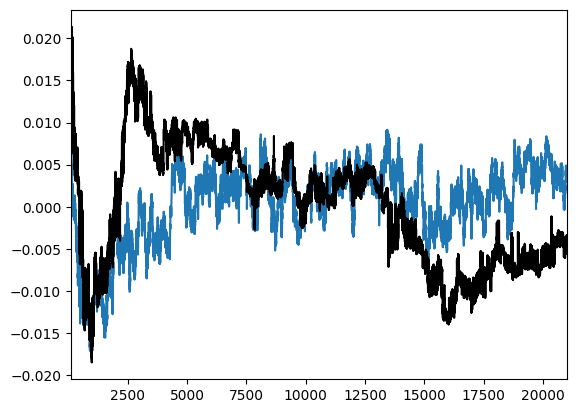

In [ ]:
# ['MU', 'MD', "ADNM", "BDNM"]
lam_vec = get_lambda(params, t_val, c_val)
lam_0 = lam_vec[0, :]
lam_1 = lam_vec[1, :]

plt.plot(t_val, (lam_0 - lam_0.mean()) - (lam_1 - lam_1.mean()) )
plt.plot(t_mean, mean_rev * .01, color = 'black')
plt.xlim(left = 100, right = 21000)  

(100.0, 21000.0)

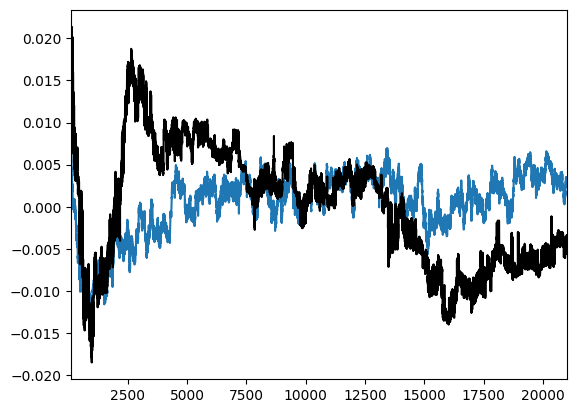

In [152]:
# ['MU', 'MD', "ADNM"]
lam_vec = get_lambda(params, t_val, c_val)
lam_0 = lam_vec[0, :]
lam_1 = lam_vec[1, :]

plt.plot(t_val, (lam_0 - lam_0.mean()) - (lam_1 - lam_1.mean()) )
plt.plot(t_mean, mean_rev * .01, color = 'black')
plt.xlim(left = 100, right = 21000)  

(100.0, 21000.0)

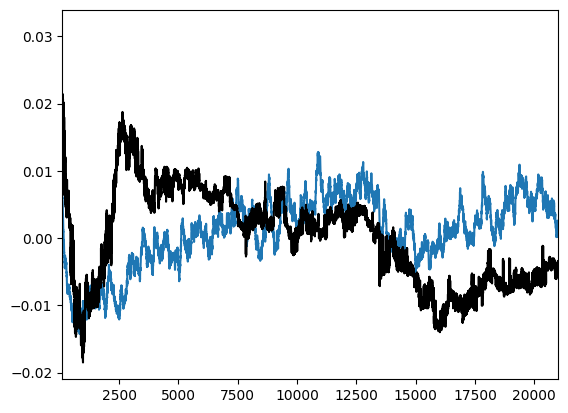

In [153]:
states_to_keep = ['MU', 'MD']
states_slice = states_df[ states_df['state'].isin(states_to_keep)].reset_index(drop=True)
state_map = {j : i for i,j in enumerate(states_to_keep)}
t_val =  states_slice['time_s'].to_numpy() 
c_val =  states_slice['state'].map(state_map).to_numpy()

multi_fit = MVH()
ll = multi_fit.fit(t = t_val, c=c_val, T = t_val[-1] + 1)

params = multi_fit.get_params()
mu_base = params[0]
alpha = params[1]
theta = params[2]

lam_vec = get_lambda(params, t_val, c_val)
lam_0 = lam_vec[0, :]
lam_1 = lam_vec[1, :]

plt.plot(t_val, (lam_0 - lam_0.mean()) - (lam_1 - lam_1.mean()) )
plt.plot(t_mean, mean_rev * .01, color = 'black')
plt.xlim(left = 100, right = 21000)  

(100.0, 21000.0)

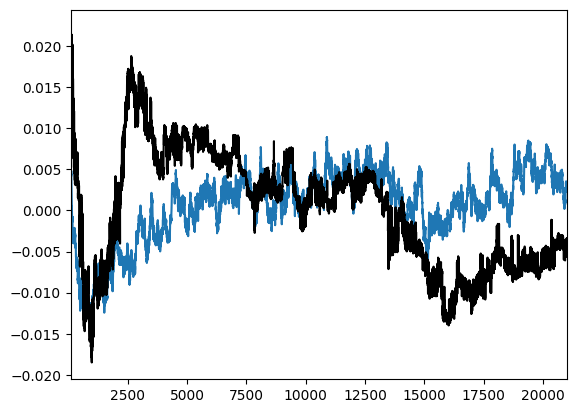

In [154]:
states_to_keep = ['MU', 'MD', "BDNM"]
states_slice = states_df[ states_df['state'].isin(states_to_keep)].reset_index(drop=True)
state_map = {j : i for i,j in enumerate(states_to_keep)}
t_val =  states_slice['time_s'].to_numpy() 
c_val =  states_slice['state'].map(state_map).to_numpy()

multi_fit = MVH()
ll = multi_fit.fit_const_theta(theta = .009, t = t_val, c=c_val, T = t_val[-1] + 1)

params = multi_fit.get_params()
mu_base = params[0]
alpha = params[1]
theta = params[2]

lam_vec = get_lambda(params, t_val, c_val)
lam_0 = lam_vec[0, :]
lam_1 = lam_vec[1, :]

plt.plot(t_val, (lam_0 - lam_0.mean()) - (lam_1 - lam_1.mean()) )
plt.plot(t_mean, mean_rev * .01, color = 'black')
plt.xlim(left = 100, right = 21000)  

(100.0, 21000.0)

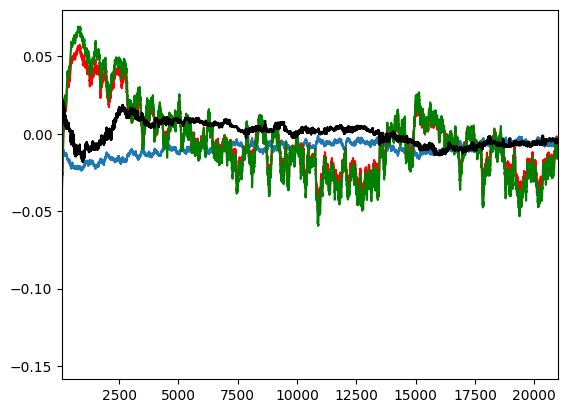

In [161]:
plt.plot(t_val, lam_0  - lam_1 )
plt.plot(t_val, lam_0-lam_0.mean(), color = 'red')
plt.plot(t_val, lam_1-lam_1.mean(), color = 'green')


plt.plot(t_mean, mean_rev * .01, color = 'black')
plt.xlim(left = 100, right = 21000) 

In [398]:
from scipy.ndimage import gaussian_filter1d

def derv_left(x, y, N=10):
    dy_dx = np.full_like(y, np.nan, dtype=float)
    for i in range(N, len(y)):
        xi = x[i-N:i]
        yi = y[i-N:i]
        A = np.vstack([xi - xi.mean(), np.ones(N)]).T
        m, _ = np.linalg.lstsq(A, yi, rcond=None)[0]
        dy_dx[i] = m
    return dy_dx

def derv2_left(x, y, N=10):
    """
    Causal second derivative via rolling quadratic fit on the last N points.
    At index i, fit y ~ a*(x-x0)^2 + b*(x-x0) + c over x[i-N:i], with x0=x[i-1].
    Then y''(x[i-1]) = 2*a.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    d2 = np.full_like(y, np.nan, dtype=float)

    for i in range(N, len(y)):
        xi = x[i-N:i]
        yi = y[i-N:i]
        if np.ptp(xi) == 0:  # all x equal -> undefined
            continue
        x0 = xi[-1]          # expand at the latest (causal)
        u = xi - x0
        A = np.vstack([u**2, u, np.ones_like(u)]).T  # [a, b, c]
        a, b, c = np.linalg.lstsq(A, yi, rcond=None)[0]
        d2[i] = 2.0 * a
    return d2

def causal_moving_average(x, w=500, min_periods=1):
    x = np.asarray(x, dtype=float)
    k = np.ones(w, dtype=float)

    # numerator: replace NaNs by 0 so they don't contribute
    num = np.convolve(np.nan_to_num(x, nan=0.0), k, mode='full')[:len(x)]
    # denominator: how many non-nan samples in each causal window
    den = np.convolve(~np.isnan(x), k, mode='full')[:len(x)].astype(float)

    # enforce min_periods (like pandas)
    valid = den >= max(1, min_periods)
    out = np.full_like(num, np.nan, dtype=float)
    out[valid] = num[valid] / den[valid]
    return out


t_val_s = t_val / 10000
def causal_convolve(x, w=500):
    kernel = np.ones(w) / w
    return np.convolve(x, kernel, mode='full')[:len(x)]

y_smooth = causal_moving_average(lam_0  - lam_1,  w=600)

grad = derv_left(y_smooth, t_val_s, N=50)
grad_smooth = causal_moving_average(grad, w = 3000) 

# grad_2 = derv2_left(y_smooth, t_val,  N=12)
# grad_smooth_2 = causal_moving_average(grad_2, w = 200) 

int_trans = np.pow(10,lam_0  - lam_1) - np.pow(10,lam_0  - lam_1).mean()
smooth_trans = causal_convolve(int_trans)


(-0.04, 0.03)

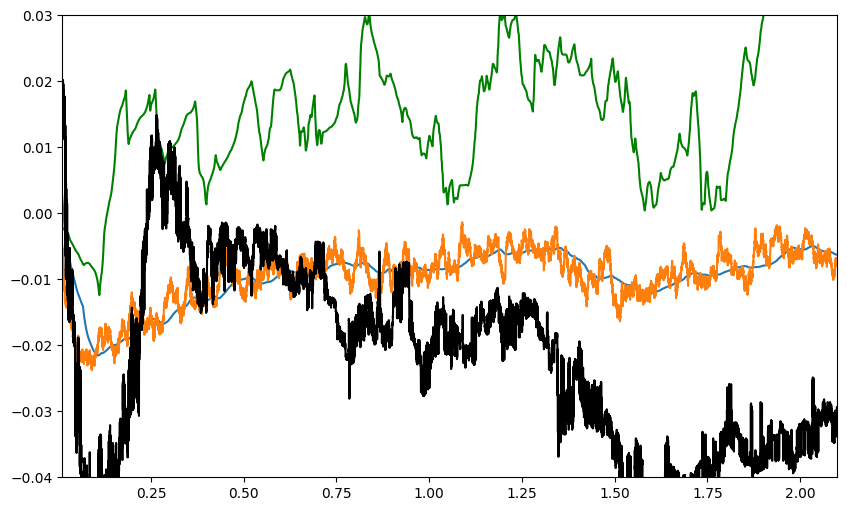

In [403]:

plt.subplots(figsize=(10, 6))
# plt.plot(t_val, smooth_trans)
plt.plot(t_val_s, y_smooth)
#plt.plot(t_val, grad*2000)
plt.plot(t_val_s, lam_0 - lam_1)
plt.plot(t_val_s, grad_smooth / 1000 * 2, color = "green")
# plt.plot(t_val, grad_smooth_2 /  10e12, color = 'red')


plt.plot(t_mean/ 10000, mean_rev * .02, color = 'black')
plt.xlim(left = 100/ 10000, right = 21000/ 10000) 
plt.ylim(bottom = -.04, top = .03)

# Experiments 
Want to understand how parameters change throughout the day, and if there is any trends that generalize over the different months. 
1) For every hour recompute the required parameters,  get net loglikehood per day 
2) for every hour recompute the parameters with a fixed beta, get net loglikehood per day 
4) Construct a normalized spline for all parameters, see how it predicts residauls vs baseline model 

## Variable Theta

In [ ]:
all_records = {} 

states_to_keep = ['MU', 'MD', "ADNM"]
state_map = {j : i for i,j in enumerate(states_to_keep)}
root_dir  =  "dataset/AAPL_BBO_1s/"

data_dir = Path(root_dir)
hour_blocks =[[9,10], [11,12], [13,14]]

for file in data_dir.glob("*.zst"):
    print("--------------- " + root_dir + file.name)

    states_df, df = BBO_1_preproccess(root_dir + file.name)
    current_day = df['ts_recv'].dt.day.iloc[0]

    # hours = states_df['ts_recv_curr'].dt.hour.unique()
    states_df_simp = states_df[states_df['state'].isin(states_to_keep)].reset_index(drop=True)
    states_df_simp['state'] = states_df_simp['state'].map(state_map)

    for i, blk in enumerate(hour_blocks):
        state_hour = states_df_simp[states_df_simp['ts_recv_curr'].dt.hour.isin(blk)].reset_index(drop=True)
        t = (state_hour['time_s'] - state_hour['time_s'].iloc[0]).to_numpy()
        c = state_hour['state'].to_numpy()

        multi_hawk = MVH()
        ll = multi_hawk.fit(t = t, c=c, T = t[-1] + 1)

        params = multi_hawk.get_params()
        record= params_to_entry(params)
        record['LL'] = ll

        entry_name = str(current_day) + f"_B{i}"

        all_records[entry_name] = record
        print((i+1)/len(hour_blocks)*100, " percent complete --- ", entry_name)

pd.DataFrame(all_records).to_csv("hawkes_market_results.csv")

--------------- dataset/AAPL_BBO_1s/equs-mini-20251006.bbo-1s.csv.zst
33.33333333333333  percent complete ---  6_B0
66.66666666666666  percent complete ---  6_B1
100.0  percent complete ---  6_B2
--------------- dataset/AAPL_BBO_1s/equs-mini-20251007.bbo-1s.csv.zst
33.33333333333333  percent complete ---  7_B0
66.66666666666666  percent complete ---  7_B1
100.0  percent complete ---  7_B2
--------------- dataset/AAPL_BBO_1s/equs-mini-20251009.bbo-1s.csv.zst
33.33333333333333  percent complete ---  9_B0
66.66666666666666  percent complete ---  9_B1
100.0  percent complete ---  9_B2
--------------- dataset/AAPL_BBO_1s/equs-mini-20251013.bbo-1s.csv.zst
33.33333333333333  percent complete ---  13_B0
66.66666666666666  percent complete ---  13_B1
100.0  percent complete ---  13_B2
--------------- dataset/AAPL_BBO_1s/equs-mini-20251014.bbo-1s.csv.zst
33.33333333333333  percent complete ---  14_B0
66.66666666666666  percent complete ---  14_B1
100.0  percent complete ---  14_B2
--------------

In [ ]:
records_df = pd.DataFrame(all_records).T
records_df['blk'] = records_df.index.str.split("_").map(lambda x: x[1][1])

In [40]:
records_df[records_df['blk'] == '2']

,00,01,02,10,11,12,20,21,22,mu_0,mu_1,mu_2,theta,LL,blk
6_B2,0.351226,0.177732,0.000780,0.301174,0.207219,0.001316,0.217001,0.015074,0.239168,0.109149,0.184086,0.021621,0.005929,-10535.025496,2
7_B2,0.146531,0.117592,0.017060,0.082064,0.210036,0.017196,0.078957,0.104736,0.036696,0.232097,0.200248,0.022518,0.007149,-10625.725098,2
9_B2,0.131230,0.062307,0.023367,0.073291,0.113192,0.025228,0.067046,0.052578,0.056939,0.240454,0.231975,0.014756,0.007130,-10366.963781,2
13_B2,0.099356,0.231840,0.007666,0.112701,0.340167,0.005233,0.051012,0.055972,0.154418,0.232276,0.133907,0.020066,0.005873,-10442.417800,2
14_B2,0.161483,0.094406,0.014695,0.092708,0.167818,0.016712,0.083816,0.086062,0.030071,0.240775,0.219426,0.012184,0.006484,-10474.297109,2
16_B2,0.112930,0.093435,0.004920,0.079169,0.170085,0.003673,0.025359,0.025960,0.358775,0.309746,0.279497,0.009794,0.008936,-11476.237732,2
20_B2,0.154260,0.085442,0.008726,0.081594,0.157597,0.011587,0.079208,0.078569,0.032410,0.243756,0.232685,0.017615,0.005744,-10580.435546,2
21_B2,0.170065,0.172382,0.000546,0.186627,0.199889,0.000393,0.006711,0.005301,0.393497,0.188121,0.168522,0.025134,0.012927,-10370.747637,2
23_B2,0.133320,0.195000,0.002381,0.120048,0.273423,0.004659,0.026241,0.054071,0.160480,0.193839,0.123843,0.039261,0.012859,-9989.204885,2
27_B2,0.263483,0.077573,0.009886,0.145294,0.130954,0.024985,0.131707,0.058542,0.027836,0.114536,0.136405,0.039056,0.009324,-8555.350818,2


## Fixed Theta

In [132]:
theta_test = [.005, .009, .015, .10]

In [133]:
all_records = {} 

states_to_keep = ['MU', 'MD', "ADNM"]
state_map = {j : i for i,j in enumerate(states_to_keep)}
root_dir  =  "dataset/AAPL_BBO_1s/"

data_dir = Path(root_dir)
hour_blocks =[[9,10], [11,12], [13,14]]

for file in data_dir.glob("*.zst"):
    print("--------------- " + root_dir + file.name)

    states_df, df = BBO_1_preproccess(root_dir + file.name)
    current_day = df['ts_recv'].dt.day.iloc[0]

    # hours = states_df['ts_recv_curr'].dt.hour.unique()
    states_df_simp = states_df[states_df['state'].isin(states_to_keep)].reset_index(drop=True)
    states_df_simp['state'] = states_df_simp['state'].map(state_map)

    
    j = 0 
    n_step = len(theta_test) * len(hour_blocks)
    for theta in theta_test:
        for i, blk in enumerate(hour_blocks):
            state_hour = states_df_simp[states_df_simp['ts_recv_curr'].dt.hour.isin(blk)].reset_index(drop=True)
            t = (state_hour['time_s'] - state_hour['time_s'].iloc[0]).to_numpy()
            c = state_hour['state'].to_numpy()

            multi_hawk = MVH()
            ll = multi_hawk.fit_const_theta(theta =theta, t = t, c=c, T = t[-1] + 1)

            params = multi_hawk.get_params()
            record= params_to_entry(params)
            record['LL'] = ll

            entry_name = str(current_day) +  f"_T{theta}"+ f"_B{i}"

            all_records[entry_name] = record

            j +=1 
            print(j / n_step, " percent complete --- ", entry_name)

pd.DataFrame(all_records).to_csv("hawkes_market_results_fixed_theta.csv")


--------------- dataset/AAPL_BBO_1s/equs-mini-20251006.bbo-1s.csv.zst
0.08333333333333333  percent complete ---  6_T0.005_B0
0.16666666666666666  percent complete ---  6_T0.005_B1
0.25  percent complete ---  6_T0.005_B2
0.3333333333333333  percent complete ---  6_T0.009_B0
0.4166666666666667  percent complete ---  6_T0.009_B1
0.5  percent complete ---  6_T0.009_B2
0.5833333333333334  percent complete ---  6_T0.015_B0
0.6666666666666666  percent complete ---  6_T0.015_B1
0.75  percent complete ---  6_T0.015_B2
0.8333333333333334  percent complete ---  6_T0.1_B0
0.9166666666666666  percent complete ---  6_T0.1_B1
1.0  percent complete ---  6_T0.1_B2
--------------- dataset/AAPL_BBO_1s/equs-mini-20251007.bbo-1s.csv.zst
0.08333333333333333  percent complete ---  7_T0.005_B0
0.16666666666666666  percent complete ---  7_T0.005_B1
0.25  percent complete ---  7_T0.005_B2
0.3333333333333333  percent complete ---  7_T0.009_B0
0.4166666666666667  percent complete ---  7_T0.009_B1
0.5  percent com

## Analysis

In [134]:
records_df = pd.read_csv("hawkes_market_results.csv", index_col=0).T
records_fixedT_df = pd.read_csv("hawkes_market_results_fixed_theta.csv", index_col=0).T

# Remapping 
records_df['blk'] = records_df.index.str.split("_").map(lambda x: x[-1][1])
blk_hr = {"0": (9+11)/2,
          "1": (11+13)/2,
          "2": (13+15)/2,}
records_df['blk_hr'] = records_df['blk'].map(blk_hr)

# Remapping
records_fixedT_df['blk'] = records_fixedT_df.index.str.split("_").map(lambda x: x[-1][1])
blk_hr = {"0": (9+11)/2,
          "1": (11+13)/2,
          "2": (13+15)/2,}
records_fixedT_df['blk_hr'] = records_fixedT_df['blk'].map(blk_hr)


### Boxplots

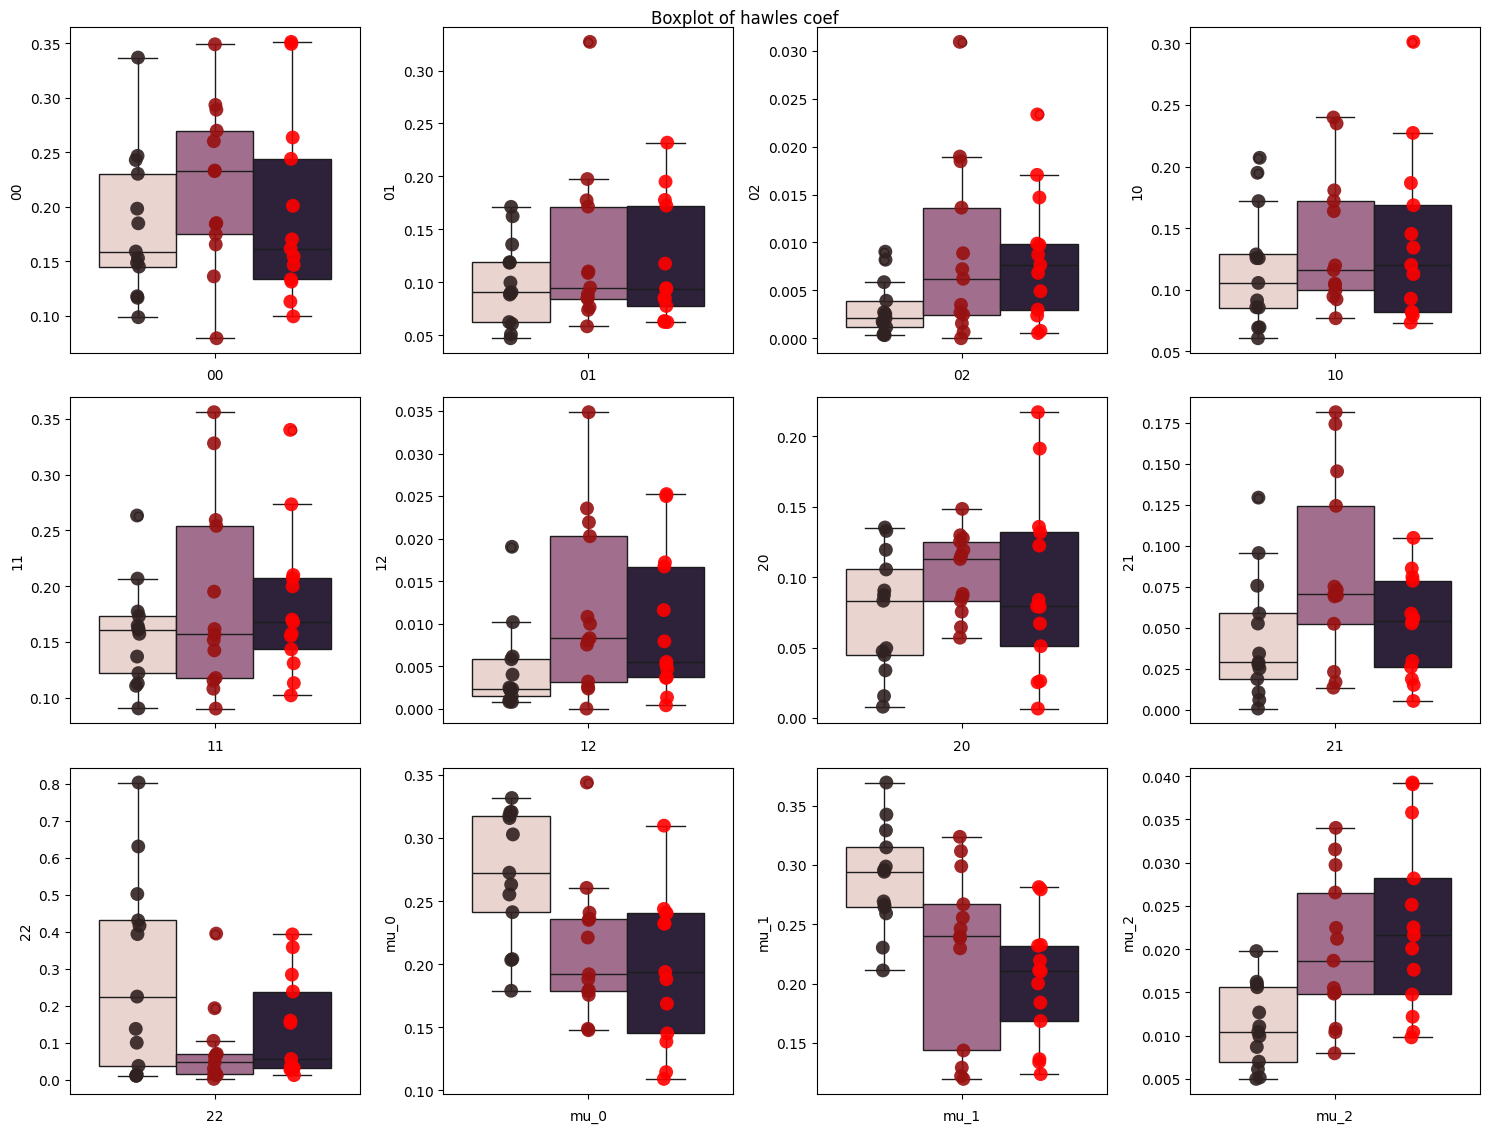

In [75]:
cols = records_df.columns[:-4]
n_cols = 4 

fig, axes = plt.subplots(nrows=len(cols) // n_cols + 1, ncols=n_cols, figsize=(15, 15))
axes = axes.flatten()
fig.suptitle('Boxplot of hawles coef')

for i, feature in enumerate(cols):
    ax = axes[i]
    sns.boxplot(data=records_df, y=feature, hue = 'blk_hr',ax=ax)
    sns.stripplot(data=records_df, y=feature, ax=ax,
                hue='blk_hr', dodge=True, palette='dark:red', size=10, alpha=0.9, jitter=0.02)

    ax.set_xlabel(feature)
    ax.legend_.remove()

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

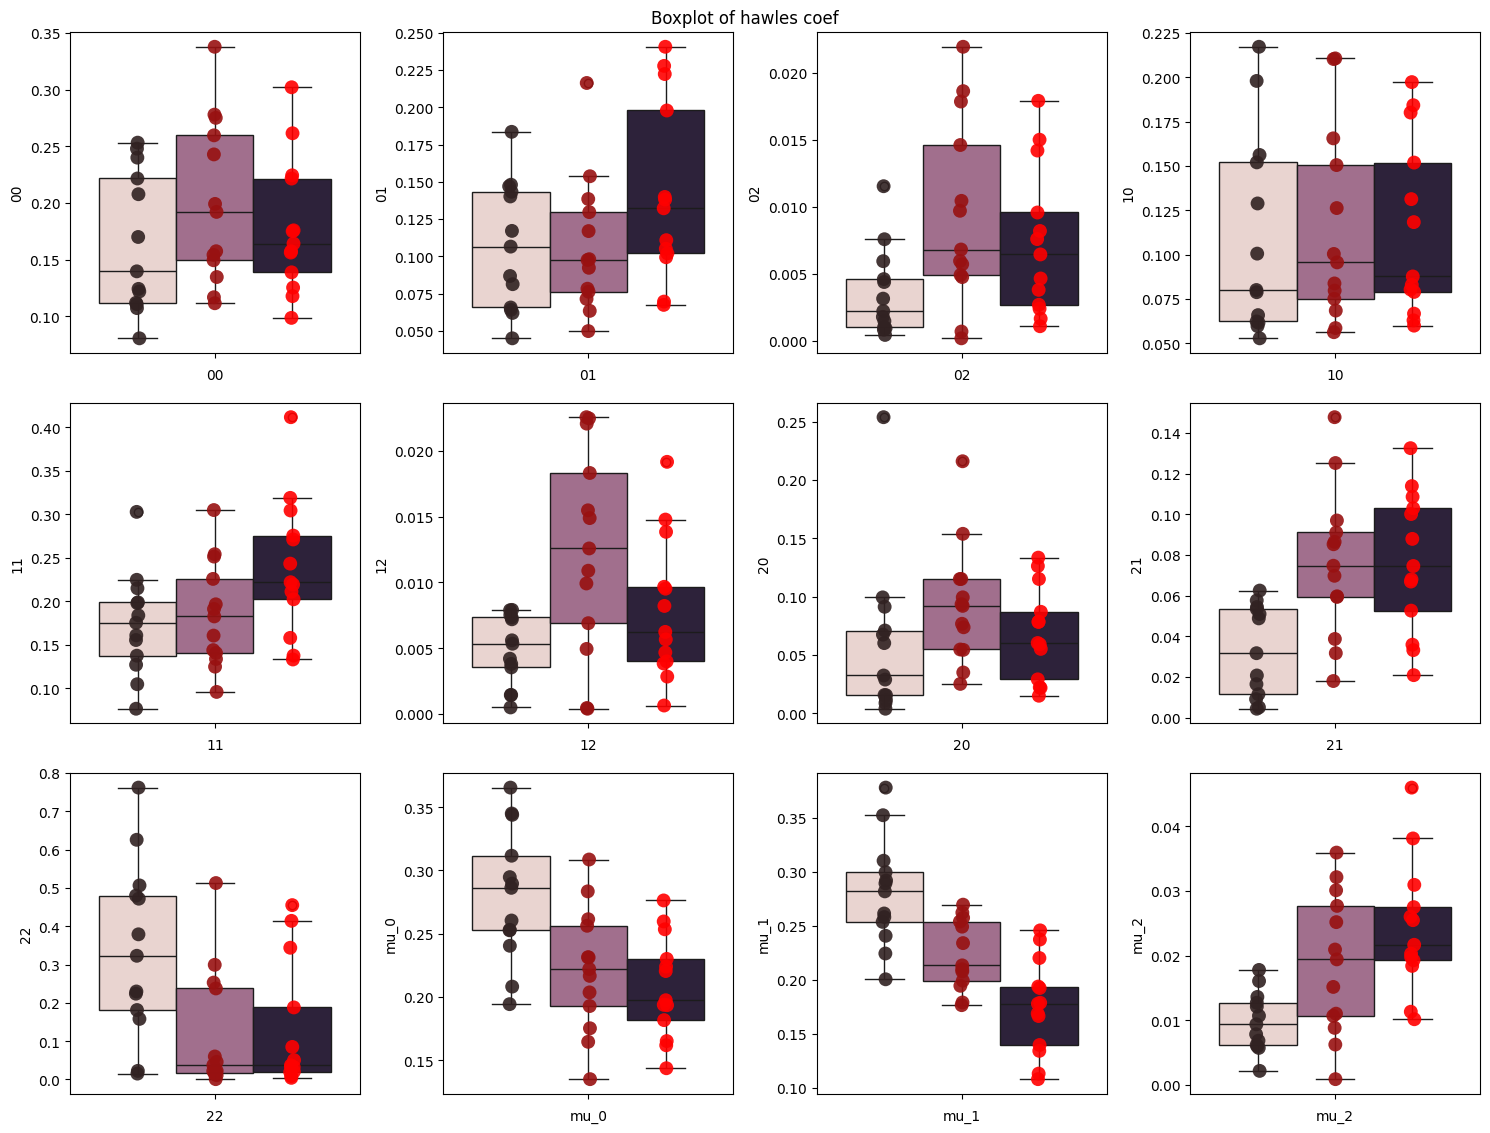

In [81]:
df = records_fixedT_df[records_fixedT_df['theta'] == .007]

cols = df.columns[:-4]
n_cols = 4 

fig, axes = plt.subplots(nrows=len(cols) // n_cols + 1, ncols=n_cols, figsize=(15, 15))
axes = axes.flatten()
fig.suptitle('Boxplot of hawles coef')

for i, feature in enumerate(cols):
    ax = axes[i]
    sns.boxplot(data=df, y=feature, hue = 'blk_hr',ax=ax)
    sns.stripplot(data=df, y=feature, ax=ax,
                hue='blk_hr', dodge=True, palette='dark:red', size=10, alpha=0.9, jitter=0.02)

    ax.set_xlabel(feature)
    ax.legend_.remove()

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Mean and std results

#### Var Theta 

In [ ]:
mean_vals_varT = records_df.groupby('blk').mean()
mean_vals_varT.columns = [f"{col}_mean" for col in mean_vals_varT.columns]
mean_vals_varT.reset_index(inplace=True)
mean_vals_varT

,blk,00_mean,01_mean,02_mean,10_mean,11_mean,12_mean,20_mean,21_mean,22_mean,mu_0_mean,mu_1_mean,mu_2_mean,theta_mean,LL_mean,blk_hr_mean
0,0,0.182888,0.099668,0.003080,0.117018,0.156874,0.004499,0.073289,0.043306,0.286219,0.271327,0.288160,0.011047,0.008293,-8491.084532,10.0
1,1,0.219345,0.127255,0.008866,0.138352,0.187469,0.011792,0.102527,0.083683,0.080270,0.211370,0.225135,0.019895,0.008582,-10752.664452,12.0
2,2,0.193686,0.116745,0.008431,0.138823,0.182424,0.009847,0.093559,0.051236,0.140185,0.196722,0.201054,0.022799,0.008022,-10335.214278,14.0


In [ ]:
std_vals_varT = records_df.groupby('blk').std()
std_vals_varT.columns = [f"{col}_std" for col in std_vals_varT.columns]
std_vals_varT.reset_index(inplace=True)
std_vals_varT

,blk,00_std,01_std,02_std,10_std,11_std,12_std,20_std,21_std,22_std,mu_0_std,mu_1_std,mu_2_std,theta_std,LL_std,blk_hr_std
0,0,0.066883,0.040244,0.002901,0.048274,0.045370,0.005130,0.043115,0.037906,0.262947,0.052054,0.044405,0.004740,0.001819,227.678148,0.0
1,1,0.073928,0.074312,0.009223,0.054559,0.085901,0.010330,0.028341,0.056290,0.107865,0.053502,0.072894,0.008514,0.003939,610.978713,0.0
2,2,0.084077,0.057418,0.006727,0.067654,0.065800,0.008563,0.063626,0.030795,0.136821,0.059628,0.050904,0.010303,0.002410,717.730991,0.0


#### Fixed Theta

In [135]:
mean_vals_fixT = records_fixedT_df.groupby(['blk', 'theta']).mean()
mean_vals_fixT.columns = [f"{col}_mean" for col in mean_vals_fixT.columns]
mean_vals_fixT.reset_index(inplace=True)
mean_vals_fixT

,blk,theta,00_mean,01_mean,02_mean,10_mean,11_mean,12_mean,20_mean,21_mean,22_mean,mu_0_mean,mu_1_mean,mu_2_mean,LL_mean,blk_hr_mean
0,0,0.005,0.155515,0.079774,0.004618,0.096098,0.146554,0.007369,0.034903,0.022577,0.333648,0.291210,0.300819,0.008547,-8490.556302,10.0
1,0,0.009,0.191294,0.085116,0.004548,0.115483,0.159827,0.006082,0.072395,0.045254,0.253370,0.266382,0.292964,0.010510,-8491.271461,10.0
2,0,0.015,0.184379,0.102430,0.002697,0.153893,0.134791,0.005764,0.098699,0.024396,0.254852,0.254671,0.295076,0.011150,-8492.679463,10.0
3,0,0.100,0.002947,0.032548,0.000059,0.041724,0.003694,0.001906,0.026919,0.000482,0.078630,0.367185,0.371840,0.017110,-8492.782982,10.0
4,1,0.005,0.203144,0.129788,0.008426,0.109643,0.196265,0.013971,0.075834,0.069295,0.156077,0.223864,0.213338,0.018053,-10754.212294,12.0
5,1,0.009,0.188232,0.132157,0.012989,0.108650,0.204011,0.015785,0.082489,0.087017,0.099265,0.226094,0.208838,0.016952,-10753.830757,12.0
6,1,0.015,0.199160,0.133400,0.006615,0.134659,0.184993,0.012043,0.094551,0.072160,0.123399,0.217325,0.214904,0.019646,-10754.027185,12.0
7,1,0.100,0.006429,0.059243,0.000188,0.082826,0.006918,0.002566,0.014499,0.001447,0.037765,0.296286,0.298755,0.026268,-10752.895710,12.0
8,2,0.005,0.187634,0.101404,0.013628,0.108612,0.185183,0.019715,0.075862,0.056074,0.143619,0.206828,0.205916,0.019108,-10336.604547,14.0
9,2,0.009,0.216225,0.103984,0.010394,0.137140,0.176031,0.012782,0.109273,0.063123,0.161540,0.189800,0.204170,0.021163,-10336.366703,14.0


In [404]:
std_vals_fixT = records_fixedT_df.groupby(['blk', 'theta']).std()
std_vals_fixT.columns = [f"{col}_std" for col in std_vals_fixT.columns]
std_vals_fixT.reset_index(inplace=True)
std_vals_fixT

,blk,theta,00_std,01_std,02_std,10_std,11_std,12_std,20_std,21_std,22_std,mu_0_std,mu_1_std,mu_2_std,LL_std,blk_hr_std
0,0,0.005,0.051879,0.021886,0.004717,0.043681,0.039619,0.006721,0.029407,0.013399,0.257705,0.048536,0.031281,0.004476,227.565798,0.0
1,0,0.009,0.047424,0.022528,0.003301,0.048682,0.043257,0.004438,0.034095,0.032525,0.244549,0.034803,0.040662,0.004521,228.272434,0.0
2,0,0.015,0.064315,0.047728,0.003464,0.066062,0.058716,0.006000,0.117159,0.023475,0.202196,0.053289,0.046495,0.005264,227.699362,0.0
3,0,0.100,0.003443,0.014307,0.000184,0.029821,0.003407,0.002751,0.064375,0.001286,0.056937,0.035657,0.032486,0.005130,223.651565,0.0
4,1,0.005,0.060761,0.062218,0.008877,0.038008,0.066925,0.011083,0.036012,0.031886,0.176055,0.045914,0.042263,0.009846,610.898459,0.0
5,1,0.009,0.056829,0.090494,0.012102,0.046987,0.055280,0.013201,0.036933,0.030985,0.131799,0.037503,0.044552,0.009760,611.326633,0.0
6,1,0.015,0.069234,0.060744,0.006189,0.057537,0.062863,0.010871,0.048393,0.036555,0.148034,0.060711,0.047141,0.010262,612.677141,0.0
7,1,0.100,0.006108,0.053836,0.000559,0.059819,0.009814,0.003530,0.031584,0.002257,0.058543,0.053977,0.050187,0.011395,611.608404,0.0
8,2,0.005,0.052604,0.043268,0.009514,0.039326,0.057158,0.027407,0.040636,0.027461,0.158106,0.042531,0.044478,0.009095,718.182199,0.0
9,2,0.009,0.070140,0.051244,0.007684,0.061708,0.068513,0.011132,0.089360,0.039905,0.163588,0.053002,0.041034,0.013158,717.972409,0.0


### Spline fitting

[]

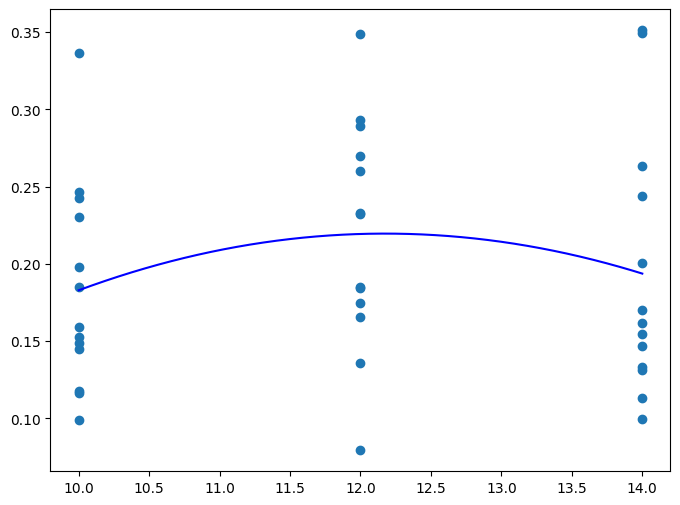

In [ ]:
x = mean_vals_varT['blk_hr_mean']
y = mean_vals_varT['00_mean']

spline = make_interp_spline(x, y, k=2)

# Evaluate on a dense grid to visualize smoothness
x_dense = np.linspace(x.min(), x.max(), 300)
y_dense = spline(x_dense)

plt.figure(figsize=(8, 6))
plt.plot(x_dense, y_dense, label='Spline Fit', color='blue')

plt.scatter(records_df['blk_hr'], records_df['00'])
plt.plot()


# Residal Compensator 

Lets start by just taking the median parameter across all states - using that as our baseline, then appling a resiudal compensator 


In [11]:
records_fixedT_df = pd.read_csv("hawkes_market_results_fixed_theta.csv", index_col=0).T

In [18]:
# Define our desired theta 
theta = .009

# Recall states we are fitting with 
states_to_keep = ['MU', 'MD', "ADNM"]
state_map = {j : i for i,j in enumerate(states_to_keep)}
num_parms = len(states_to_keep)

# Get the average value under our theta paramter
params_df = records_fixedT_df[records_fixedT_df['theta'] == theta].drop(['LL', 'theta'], axis =1).mean()

# extract parameters
a = params_df[:-num_parms]
mu = params_df[len(params_df) - num_parms:]
mu = mu.to_numpy()
a = a.to_numpy().reshape((num_parms,num_parms))

# Pass to new model
hawkes_gamma_model = MVH()
hawkes_gamma_model.set_params( mu =mu, A=a, theta=theta)

In [20]:
# get a new dataset we havent seen before 
states_df,  df = BBO_1_preproccess("dataset/AAPL_BBO_1s/validation/equs-mini-20251015.bbo-1s.csv.zst")

states_df = states_df[states_df['state'].isin(states_to_keep)]
states_df['state'] = states_df['state'].map(state_map)

t=  states_df['time_s'].to_numpy()
c = states_df['state'].to_numpy()

lam = get_lambda(hawkes_gamma_model.get_params(), t_val = t , c_val = c)

In [21]:
state_study = 0 

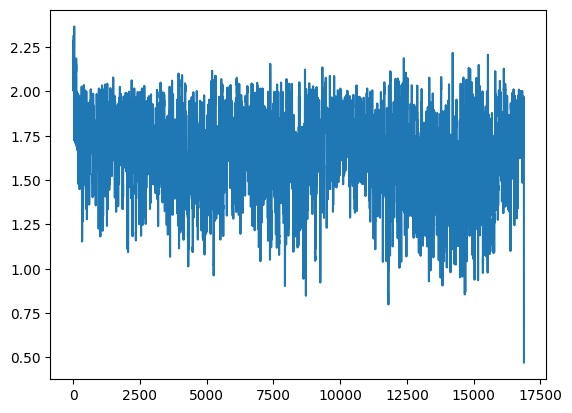

In [126]:
S = get_states(num_states =num_parms, theta = theta, t_val =t, c_val = c)
compensator = get_compensator_increments(mu = mu, A = a , t_val = t , state_machine= S)
Lam_0 = compensator[state_study, :]

# Compute residuals 
w = 10
res_sum = np.convolve(Lam_0, np.ones(w), mode='valid')
delta = (w)/ (res_sum) 

# here delta each represents the nth callback 
Lam_next   = Lam_0[w:]     # intervals w..L-1 (length L-w)
delta_prev  = delta[:-1]   # scales for intervals  w..L-1 (length L-w)
Lam_corr = delta_prev * Lam_next


plt.plot(delta)

In [123]:
print(Lam_corr.mean(), Lam_corr.var(),Lam_next.mean(), Lam_next.var())

0.8048322610354715 0.09537167258771707 0.6271217903427513 0.061048026588821705


0.15666247437689187 0.061050046969118324 1.0155191470630427


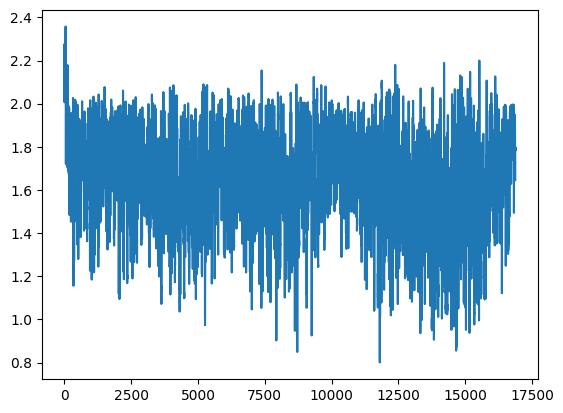

In [130]:
rho = .8

delta_prev_prev = delta[:-2]
delta_prev  = delta[1:-1] 
delta_corr = np.log(delta_prev_prev) * (1-rho) + rho*np.log(delta_prev)
Lam_next   = Lam_0[w+1:]
Lam_corr = np.exp(delta_corr) * Lam_next


print(Lam_corr.var(),Lam_next.var(), Lam_corr.mean())

plt.plot(np.exp(delta_corr))

# L0 L1 L2 L3 L4 Lam_next 
# NA D0 D1 D2 D3 delta_prev 
# NA NA D0 D1 D2 delta_prev_prev


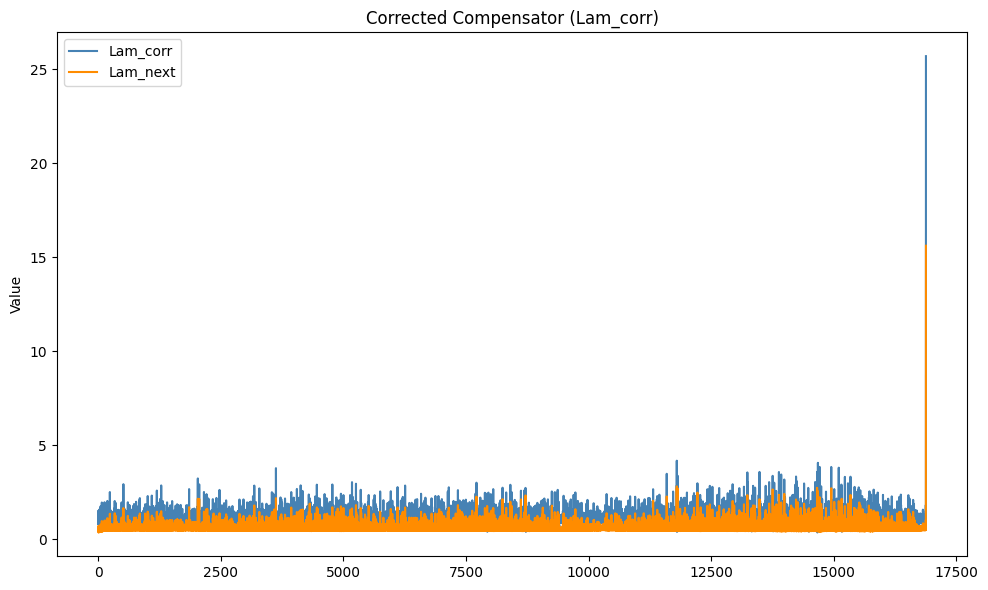

In [134]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

axes.plot(Lam_corr, color='steelblue', label='Lam_corr')
axes.set_title("Corrected Compensator (Lam_corr)")
axes.set_ylabel("Value")

axes.plot(Lam_next, color='darkorange', label='Lam_next')
axes.legend()

plt.tight_layout()
plt.show()


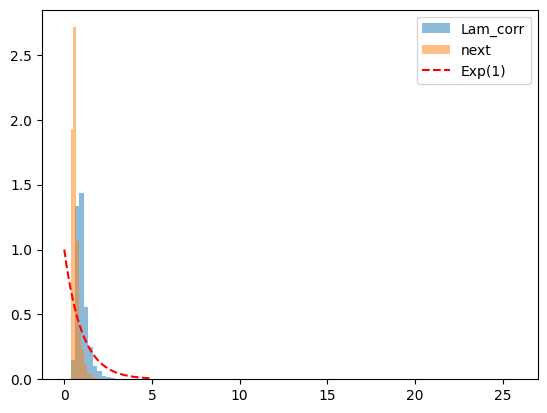

In [137]:
import scipy.stats as st

plt.hist(Lam_corr, bins=100, density=True, alpha=0.5, label='Lam_corr')
plt.hist(Lam_next, bins=100, density=True, alpha=0.5, label='next')

x = np.linspace(0, 5, 200)
plt.plot(x, st.expon.pdf(x), 'r--', label='Exp(1)')
plt.legend(); plt.show()


# Class setup

Will be used to track model state on live data, injests row 

In [844]:

class hawkes_system(): 

    def __init__(self, buffer_window = 50, residual_window=20,feature_window = 10, OFI_buffer_window = 10,  theta = .01): 
        
        # Buffers are used for direct computations 
        # hist vectors are used for plotting later 

        self.mu = np.array([0.22742546, 0.23532417, 0.01620813])
        self.a = np.array([
            [0.19858365, 0.107086  , 0.00931048],
            [0.12042455, 0.17995655, 0.01154943],
            [0.08805226, 0.06513124, 0.17139197]
            ])
        
        self.theta= theta

        self.hawkes_gamma_model = MVH()
        self.hawkes_gamma_model.set_params(mu = self.mu, A = self.a, theta = self.theta)

        self.active_states = ['MU', 'MD', "ADNM"]
        self.state_map = {j : i for i,j in enumerate(self.active_states )}
        self.num_states = len(self.active_states)

        self.i = 0 # Counts the number of states that have been successfully read (non idle)
        self.input_buffer_short = None # previous row used to quickly get next state 

        # Long buffer used to store values for the residual compensator, and the real time deriviative pricing 
        # (time_sec, state, price_off_open, price, bid_px, ask_px, bid_sz, ask_sz, mid_price) 
        self.buffer_window = buffer_window
        self.input_buffer_long = deque(maxlen=self.buffer_window) 
        self.input_hist = deque()
    

        # Reference indexs - not great
        self.mid_price_idx = 8
        self.state_idx = 1
        self.bid_sz_idx = 6
        self.time_idx =0 
        self.price_off_open = 2
        self.bid_px_idx = 4
        self.ask_px_idx = 5
        self.ask_sz_idx = 7

        # Define hawkes inputs, just derived from the current buffers 
        self.t_c = deque() 
        self.t_start = None # actual time value to start from 

        # Dealing with states 
        self.current_state = np.zeros((self.num_states, self.num_states))
        self.state_up_to_date = False #boolean to determine if the state has been updated yet 
        self.state_hist = deque()

        # Compensator 
        self.dLambda_hist = deque() 
        self.dLambda_buffer = deque(maxlen=3) 

        # Residual and delta setup 
        self.residual_window = residual_window

        # used directly for computing compensator values 
        self.residual_buffer = [deque(maxlen=residual_window) for i in range(self.num_states)]
        self.residual_hist = [deque() for i in range(self.num_states)] # stores residual and time values
        [element.append(0.0) for element in self.residual_buffer]

        # Just used for storing the delta history 

        self.delta_hist = [deque() for i in range(self.num_states)]
        self.delta_buffer = [deque(maxlen=2) for i in range(self.num_states)]
        self.one_step_res = [deque() for i in range(self.num_states)]

        # Price features
        self.open_price = None 

        # Feature history 
        self.feature_window = feature_window
        self.feature_hist = deque()
        self.feature_buffer = deque(maxlen= self.feature_window)
        self.feature_hist_ma = deque()

        # Order flow imbalance
        self.OFI_buffer_window  = OFI_buffer_window
        self.OFI_buffer = deque(maxlen = OFI_buffer_window)


    def read_pd_raw(self, row_curr : pd.DataFrame):
        # Check if row is valid
        valid_ind =  row_curr[['ts_event', 'price', 'bid_px_00', 'ask_px_00', 'ts_recv', 'bid_sz_00', 'ask_sz_00' ]].isna().sum(axis=1)
        if (valid_ind != 0).any(): 
            return 

        # If row is valid compute mid prie 
        row_curr['mid_price'] = (row_curr['bid_px_00'] + row_curr['ask_px_00']) / 2
        row_curr_temp =  row_curr[['ts_recv', 'price', 'bid_px_00', 
                                   'ask_px_00', 'bid_sz_00', 'ask_sz_00', 
                                   'mid_price']].to_numpy()[0]
        
        # Final format for row_curr_arr (time_sec, state, price_off_open, price, bid_px, ask_px, bid_sz, ask_sz, mid_price) 

        # Allocate 0s want to include space for the 
        row_curr_arr = np.zeros(len(row_curr_temp)+2, dtype = float) # size 9 

        # Fill with numeric values 
        row_curr_arr[3:] = row_curr_temp[1:] # 3-10 filled with values

        # Convert to time since midnight 
        dt_seconds = np.datetime64(row_curr_temp[0], 's')       

        # Add second values, 0 filled 
        row_curr_arr[self.time_idx] = (dt_seconds.astype('datetime64[s]') - dt_seconds.astype('datetime64[D]'))/ np.timedelta64(1, 's')

        if self.i == 0: 
            self.open_price = row_curr_arr[self.mid_price_idx]
            row_curr_arr[self.state_idx] = -10
            row_curr_arr[2] = row_curr_arr[self.mid_price_idx] - self.open_price

            self.input_buffer_short = row_curr_arr
            self.input_buffer_long.append(row_curr_arr)
            self.i += 1 
            return 
        

        # Add the price off open   
        row_curr_arr[2] = row_curr_arr[self.mid_price_idx] - self.open_price

        # Compute states based on short buffer value 
        if self.input_buffer_short[self.mid_price_idx]  < row_curr_arr[self.mid_price_idx]: 
            # mid price increases 
            row_curr_arr[self.state_idx] = 0 # MU 
        elif row_curr_arr[self.mid_price_idx] < self.input_buffer_short[self.mid_price_idx]: 
            # mid price down 
            row_curr_arr[self.state_idx] = 1 # MD 
        elif ((row_curr_arr[self.mid_price_idx] == self.input_buffer_short[self.mid_price_idx]) 
              & (row_curr_arr[self.ask_sz_idx] < self.input_buffer_short[self.ask_sz_idx])): 
            # if the mid price stays the same,  and the current ask size has decreased, then Ask Down No Movement 
            row_curr_arr[self.state_idx] = 2 # ADNM 
        else: # set to idle state 
            row_curr_arr[self.state_idx] = -10 # IDLE 

        # Set start date if needed
        if self.t_start is None and row_curr_arr[self.state_idx] != -10: 
            # First non idle time 
            self.t_start = row_curr_arr[self.time_idx]
        elif row_curr_arr[self.state_idx] != -10: 
            self.main_update(row_curr_arr)

        # Update long buffer 
        self.input_buffer_long.append(row_curr_arr)
        self.input_hist.append(row_curr_arr)

        # Update short buffer 
        self.input_buffer_short = row_curr_arr
        
        # Update i counter 
        self.i += 1

    def main_update(self, row_curr_arr): 
        # if t_start already set and state isnt idle
        # add the time since t_start and the state  - this is the result that will be use for the hawkes proccess directly 
        t_ = row_curr_arr[self.time_idx] - self.t_start 
        c_ = row_curr_arr[self.state_idx]
        self.t_c.append(np.array([t_, c_ ]))

        # Tell the rest of the program the state is now out of date 
        self.state_up_to_date = False 

        # Update the states
        self.update_states()

        # Update compensator increments 
        self.update_compensator_inc()

        # Update the residuals 
        self.update_residuals_delta()

    def update_states(self):

        # just a functin of t and c and the parameters 
        if self.state_up_to_date: 
            return  ""
        if len(self.t_c) < 2: 
            return ""
        
        t_cur, c_cur = self.t_c[-1]
        t_prev, c_prev = self.t_c[-2]

        c_cur = int(c_cur)

        dt = t_cur - t_prev
        if dt < 0 : 
            print('non montone')
        else:
            # Compute new state and update
            int_state_decay = np.exp(-self.theta * dt) 
            self.current_state = self.current_state * int_state_decay
            self.current_state[:, c_cur] = self.current_state[:, c_cur] +  1 
            
            # add to state history 
            self.state_hist.append(self.current_state.copy())
            self.state_up_to_date = True 

            #print("Update state successful")

            # This stores intensities AFTER the update 

    def get_state_outputs(self):
        """
        Outputs variables at current state 
        1. Hawkes intesities for each event
        2. Compensated intensties 
        3. Mid price movement off start 
        4. Derivative for mid price (with smoothing applied )
        5. Order-flow imbalance (signed volume) 
        6. Queue (book) imbalance (top of book)
        """

        if len(self.t_c) <= 2:
            return  
    
        if len(self.input_buffer_long) < 2:
            return


        t_cur, c_cur = self.t_c[-1]
        
        # -------- Intensities  
        lam = np.sum(self.current_state * self.theta  * self.a, axis = 1)  + self.mu
        lam_compensated = np.zeros(self.num_states)

        for i in range(self.num_states):
            if len(self.delta_buffer[i])  >= 1:
                lam_compensated[i] =  lam[i] *self.delta_buffer[i][-1]
        
        intensity_spread = lam[0] - lam[1]
        intensity_spread_compensated = lam_compensated[0] - lam_compensated[1]

        # -------- Price off movement 
        price_off_open = self.input_buffer_short[self.price_off_open]

        # --------  Mid price derivative + short term volatility 
        price_mov_derivative = np.nan  
        vol = np.nan 
        momentum = np.nan 

        if len(self.input_buffer_long ) >= self.buffer_window: 
            mid_prices = np.array(self.input_buffer_long)[:, self.mid_price_idx]
            
            # Price derivates 
            x = np.arange(len(mid_prices))
            slope, intercept = np.polyfit(x, mid_prices, 1)
            price_mov_derivative = slope 

            # Short term volatility 
            vol = np.std(np.diff(mid_prices))

            # momentum 
            window_m = min(5, len(mid_prices) - 1)
            if window_m > 0: momentum = mid_prices[-1] - mid_prices[-1 - window_m]

            
        
        # -------- Order flow imablance (OFI)
        OFI_inc = 0 
        current_arr = self.input_buffer_long[-1]
        prev_arr = self.input_buffer_long[-2] 

        if current_arr[self.bid_px_idx] > prev_arr[self.bid_px_idx]: OFI_inc += current_arr[self.bid_sz_idx]
        elif current_arr[self.bid_px_idx] < prev_arr[self.bid_px_idx]: OFI_inc  -= prev_arr[self.bid_sz_idx]

        if current_arr[self.ask_px_idx] < prev_arr[self.ask_px_idx]: OFI_inc -= prev_arr[self.ask_sz_idx]
        elif current_arr[self.ask_px_idx] > prev_arr[self.ask_px_idx]: OFI_inc += current_arr[self.ask_sz_idx] 
        

        self.OFI_buffer.append(OFI_inc)

        OFI_cum = np.nan
        if len(self.OFI_buffer) >= self.OFI_buffer_window: 
            OFI_cum = np.sum(np.array(self.OFI_buffer))


        # -------- Queue imbalance (QI)
        bid_sz = current_arr[self.bid_sz_idx]
        ask_sz = current_arr[self.ask_sz_idx]
        QI = bid_sz / (bid_sz + ask_sz) if bid_sz + ask_sz > 0 else .5 

        # LQ ratio
        liq_ratio = bid_sz / max(ask_sz, 1e-9)
        liq_ratio = np.clip(liq_ratio,0, 100)

        # -------- Bid spread 
        spread = current_arr[self.ask_px_idx] - current_arr[self.bid_px_idx]

        # ------- Create and export feature stack 
        # (lam, lam_compensated, price_mov_derivative, OFI, QI, mid_price, price_off_open, t_cur )
        features = np.concatenate((lam, lam_compensated, 
                                   np.array([intensity_spread, intensity_spread_compensated, spread, liq_ratio,
                                             price_mov_derivative, OFI_inc, OFI_cum, QI, vol, momentum, 
                                             current_arr[self.mid_price_idx], price_off_open, t_cur]
                                             )))

        self.feature_hist.append(features)
        self.feature_buffer.append(features)

        if len(self.feature_buffer) >= self.feature_window: 
                buf = np.array(self.feature_buffer)            # shape: (window, feat_dim)
                feature_ma = buf.mean(axis=0)                  # shape: (feat_dim,)
                feature_ma[-1] = t_cur                         # keep time as current
                self.feature_hist_ma.append(feature_ma)
        
    def update_compensator_inc(self): 
        """
        This gives us the per interval delta Lambda 
        Or how much area under the intensity curve is added between events 
        """
        if len(self.state_hist) < 2: 
            print("not enough variables to update state")
            return 

        # Only update if states are up to date 
        if self.state_up_to_date: 
            # Get state variable 
            s_plus_prev = self.state_hist[-2]

            # Get recent t values and one previous 
            t_cur, c_cur = self.t_c[-1]
            t_prev, c_prev = self.t_c[-2]

            dt = t_cur - t_prev

            if dt <= 0:
                print("non monotone")
                # Non-monotone times → better to bail than accumulate nonsense
                return 
            

            decay_factor = 1.0 - np.exp(-self.theta * dt )
            
            base_term = self.mu * dt                
            excite_term = (self.a * s_plus_prev).sum(axis=1)  * decay_factor

            dLambda = np.zeros((1,  self.num_states+ 1 ))[0]

            dLambda[0:self.num_states] = base_term + excite_term   
            dLambda[-1] = c_cur
            
            # Store in history (vector per interval)
            self.dLambda_hist.append(np.concatenate((dLambda, np.array([t_cur]))))
            self.dLambda_buffer.append(dLambda)

    def update_residuals_delta(self):
        # 1. guard
        if len(self.dLambda_buffer) < 2 :
            return

        # Get most recent dLambd value 
        dLambda = self.dLambda_buffer[-1]

        # Get most recent c value 
        t_cur, c_cur = self.t_c[-1]
        k = int(c_cur)

        # Update residuals for all states 
        for j in range(self.num_states):
            new_res = self.residual_buffer[j][-1] + dLambda[j]
            self.residual_buffer[j][-1] = new_res

        # Grab the resiudal for the state that just fired 
        state_k_residuals = np.array(self.residual_buffer[k])

        # Grab the most recent residual 
        raw_res = state_k_residuals[-1]
        
        # Want to now compute the most recent delta, and the one step error 

        # First check if we have a full window yet 
        if len(state_k_residuals) >= self.residual_window:

            # Compute the delta of the most recent window 
            mean_res = state_k_residuals.mean()
            if mean_res <=0 : 
                return 
            delta_k = 1.0 / state_k_residuals.mean()

            # Add it to the history 
            self.delta_hist[k].append(np.array([delta_k, t_cur]))

            self.delta_buffer[k].append(delta_k)

            # If we have enough deltas compute the one step resiudal 
            if len(self.delta_buffer[k]) > 1:

                # Grab previously computed delta 
                prev_delta = self.delta_buffer[k][-2]

                # Compensate current residual with previous delta 
                comp_res = raw_res * prev_delta

                # Get the one step error and append 
                self.one_step_res[k].append(np.array([comp_res, t_cur]))


        # For the state that just fired, resent the cummulative count 
        self.residual_hist[k].append(np.array([raw_res, t_cur]))
        self.residual_buffer[k].append(0.0)
        



In [ ]:
def get_feature_frames(hwk: hawkes_system, epsilon = 0.03): 
    
    feature_hist_arr = np.array(hwk.feature_hist)

    feature_names = [
        "lam_0","lam_1","lam_2",
        "lam_comp_0","lam_comp_1","lam_comp_2",
        "intensity_spread","intensity_spread_compensated",
        "spread","liq_ratio",
        "price_mov_derivative","OFI_inc","OFI_cum","QI","vol","momentum",
        "mid_price","price_off_open",
        "t_cur"
    ]
    raw_features_df = pd.DataFrame(feature_hist_arr, columns=feature_names)

    # drop rows with NaNs
    raw_features_df = raw_features_df[~raw_features_df.isnull().any(axis=1)].copy()

    # drop some columns you don't want
    raw_features_df = raw_features_df.drop(['lam_0', 'lam_1', 'lam_comp_2', 'intensity_spread'], axis=1)

    # sort by time ON THE MAIN DF
    raw_features_df = raw_features_df.sort_values("t_cur").reset_index(drop=True)

    # forward-looking average over next 5 ticks (excluding current)
    raw_features_df["avg_5_ticks"] = (
        raw_features_df["mid_price"]
        .shift(-1)       # start at t+1
        .iloc[::-1]
        .rolling(5)      # 5 future ticks
        .mean()
        .iloc[::-1]
        .reset_index(drop=True)
    )

    # drop rows where we don't have enough future data
    raw_features_df = raw_features_df[~raw_features_df["avg_5_ticks"].isna()].reset_index(drop=True)
    price_5_tick_change = raw_features_df["avg_5_ticks"] - raw_features_df["mid_price"]  # future - current

    direction_vec = np.zeros(len(price_5_tick_change))
    direction_vec[(price_5_tick_change >  epsilon).to_numpy()] =  1
    direction_vec[(price_5_tick_change < -epsilon).to_numpy()] = -1

    raw_features_df["5s_dir"]         = direction_vec
    raw_features_df["5s_price_delta"] = price_5_tick_change

    return raw_features_df.reset_index(drop=True) 


In [850]:
root = "dataset/APPL_MIX_1s"

daily_feature_list = []

for j, filename in enumerate(os.listdir(root)):
    path = f"{root}/{filename}"
    symbol_day = filename.split(".")[0]

    # Raw per-day feed
    raw_day_df = pd.read_csv(path, compression='zstd')

    # Define hawkes system 
    hwk = hawkes_system(theta=.1, feature_window=10)

    start_idx = 50
    end_idx = min(start_idx + 3600*5, len(raw_day_df)-1)

    for i in range(start_idx, end_idx):
        row = raw_day_df.loc[[i], :]
        hwk.read_pd_raw(row_curr=row)
        hwk.get_state_outputs()

    # Per-day feature frame
    day_features = get_feature_frames(hwk)
    day_features.to_csv(f"dataset/training_data_raw/{symbol_day}.csv")

    daily_feature_list.append(day_features)

    print((j+1)/len(os.listdir(root)))

# Final merge
full_training_df = pd.concat(daily_feature_list, ignore_index=True)
full_training_df.to_csv("merged_save.csv")

not enough variables to update state
not enough variables to update state
0.06666666666666667
not enough variables to update state
not enough variables to update state
0.13333333333333333
not enough variables to update state
not enough variables to update state
0.2
not enough variables to update state
not enough variables to update state
0.26666666666666666
not enough variables to update state
not enough variables to update state
0.3333333333333333
not enough variables to update state
not enough variables to update state
0.4
not enough variables to update state
not enough variables to update state
0.4666666666666667
not enough variables to update state
not enough variables to update state
0.5333333333333333
not enough variables to update state
not enough variables to update state
0.6
not enough variables to update state
not enough variables to update state
0.6666666666666666
not enough variables to update state
not enough variables to update state
0.7333333333333333
not enough variable

In [860]:
# Copy Dataframe
full_training_df_live = full_training_df.copy()

# Drop outliers 
full_training_df_live = full_training_df_live[full_training_df_live['intensity_spread_compensated'] != 0.0]
full_training_df_live = full_training_df_live[full_training_df_live['lam_comp_0'] != 0.0]
# full_training_df_live.drop('liq_ratio', axis =1, inplace = True)

# Reshuffle frame 
full_training_df_live = full_training_df_live.sample(frac=1)


In [ ]:
full_training_df_live

,lam_2,lam_comp_0,lam_comp_1,intensity_spread_compensated,spread,liq_ratio,price_mov_derivative,OFI_inc,OFI_cum,QI,vol,momentum,mid_price,price_off_open,t_cur,avg_5_ticks,5s_dir,5s_price_delta
78585,0.082668,0.415396,0.274226,0.141170,0.02,0.291667,0.000469,35.0,201.0,0.225806,0.010558,-0.030,210.320,-1.435,13925.0,210.421,1.0,0.101
228493,0.077802,0.361175,0.308125,0.053050,0.19,0.561198,-0.000231,0.0,268.0,0.359466,0.031551,0.080,264.155,9.140,13419.0,264.093,-1.0,-0.062
191622,0.092597,0.346217,0.473238,-0.127020,0.15,0.250000,-0.001626,-110.0,674.0,0.200000,0.041501,-0.065,232.735,-0.125,12630.0,232.766,1.0,0.031
186526,0.094375,0.337069,0.330926,0.006143,0.02,0.656667,-0.003513,0.0,-910.0,0.396378,0.017146,-0.045,232.820,-0.040,7208.0,232.815,0.0,-0.005
235827,0.058616,0.305219,0.348359,-0.043140,0.10,2.631579,-0.002797,138.0,-162.0,0.724638,0.125969,0.010,261.040,-0.990,2704.0,260.984,-1.0,-0.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21245,0.101194,0.366229,0.573790,-0.207561,0.02,0.243902,-0.003242,0.0,-607.0,0.196078,0.017768,-0.005,182.060,0.855,9882.0,182.040,0.0,-0.020
117027,0.089940,0.375242,0.401418,-0.026176,0.03,4.530000,-0.000171,100.0,276.0,0.819168,0.016490,0.005,196.245,-5.010,14937.0,196.225,0.0,-0.020
97881,0.084802,0.297788,0.333042,-0.035254,0.02,0.500000,0.000129,-220.0,120.0,0.333333,0.011412,0.005,207.240,-0.935,16684.0,207.242,0.0,0.002
241946,0.081377,0.321039,0.293406,0.027633,0.11,1.818182,-0.001446,310.0,-590.0,0.645161,0.023376,0.030,259.325,-2.705,8940.0,259.254,-1.0,-0.071


In [ ]:
hawkes_feature = ['lam_2', 'lam_comp_0', 'lam_com_1', 'intensity_spread_compensated']

x = full_training_df_live.drop(['5s_price_delta', '5s_dir', 'avg_5_ticks', 'price_off_open', 'mid_price'], axis =1 )
y = full_training_df_live['5s_dir']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, stratify=y
)

# --- Random forest ---
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=3,
    class_weight="balanced",     
    n_jobs=-1
)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# --- Overall Accuracy ---
print("Overall accuracy:", accuracy_score(y_test, y_pred))

# --- Accuracy per class ---
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=2))

In [ ]:
x = full_training_df_live.drop(['5s_price_delta', '5s_dir', 'avg_5_ticks', 'price_off_open', 'mid_price'], axis =1 )
y = full_training_df_live['5s_dir']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, stratify=y
)

# --- Random forest ---
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=3,
    class_weight="balanced",     
    n_jobs=-1
)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# --- Overall Accuracy ---
print("Overall accuracy:", accuracy_score(y_test, y_pred))

# --- Accuracy per class ---
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=2))

0.65      0.59      0.62  

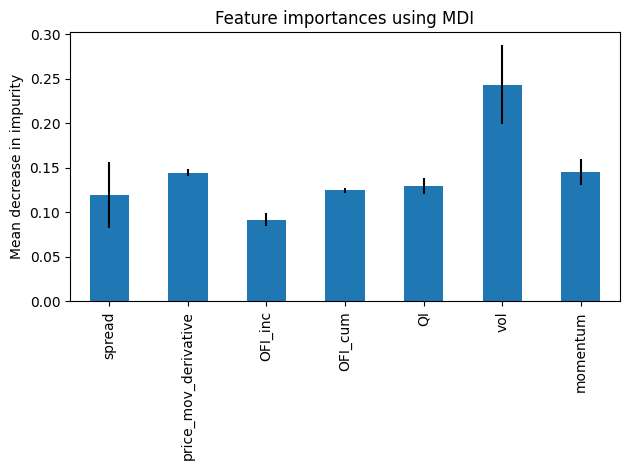

In [832]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

feature_names = x.columns.tolist()
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## Some plotting

(-2.0, 3.0)

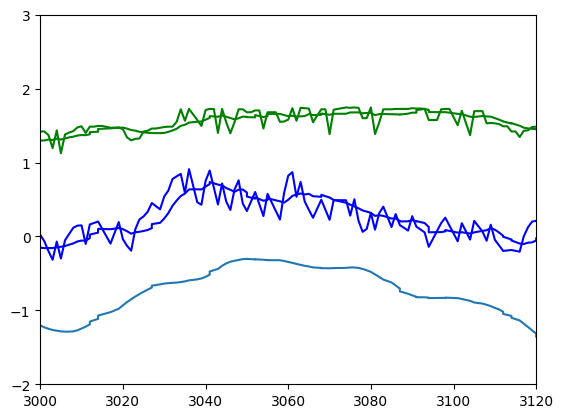

In [552]:
ma = np.array(test_hwk_sys.feature_hist_ma)[100:]
pm_a = ma[:, -2]
lam_0_ma = ma[:, 3]
lam_1_ma = ma[:, 4]
x  = ma[:, -1]

featu_raw = np.array(test_hwk_sys.feature_hist)[100:]
x_r  = featu_raw[:, -1]
lam_0_raw = featu_raw[:, 3]
lam_1_raw = featu_raw[:, 4]

plt.plot(x, ma[:, -3]*100-1)

price = np.array(test_hwk_sys.input_hist)[: , [0,2]]
price[:, 0] = price[:, 0] - test_hwk_sys.t_start
x_p = price[:, 0] 
price_raw = price[:, 1]

plt.plot(x, pm_a +2, color = 'green')
plt.plot(x_p, price_raw+2, color = 'green')

plt.plot(x, (lam_0_ma - lam_1_ma)*2, color = "blue")
plt.plot(x_r, (lam_0_raw - lam_1_raw)*2, color = "blue")

plt.xlim(3000, 3120)
plt.ylim(-2,3)
# plt.plot(x_p, price_raw+3, color = 'red')

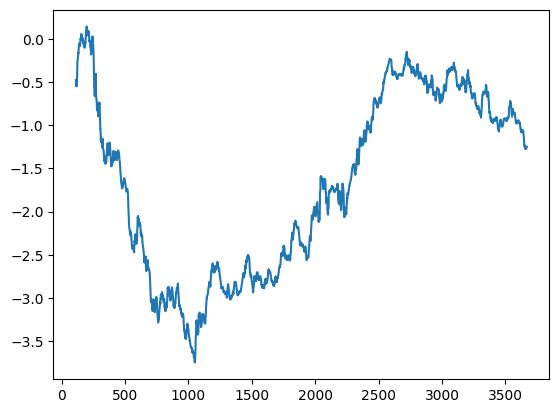

In [505]:
ma = np.array(test_hwk_sys.feature_hist_ma)[100:]
pm_a = ma[:, -2]
lam_0_ma = ma[:, 4]
x  = ma[:, -1]

plt.plot(x, pm_a)

(-5.0, 3.0)

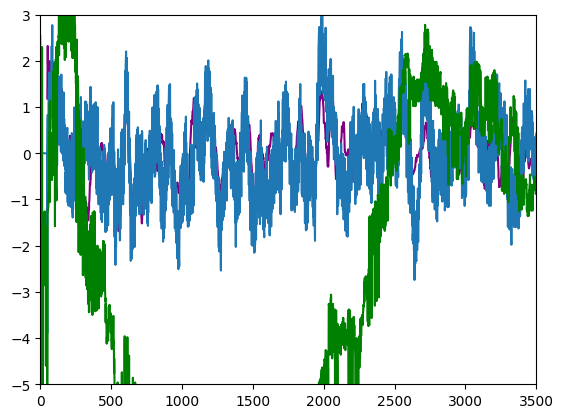

In [ ]:
# (time_sec, state, price_off_open, price, bid_px, ask_px, bid_sz, ask_sz, mid_price) 
price = np.array(test_hwk_sys.input_hist)[: , [0,2]]
price[:, 0] = price[:, 0] - test_hwk_sys.t_start
x_p = price[:, 0] 

features_slice = np.array(test_hwk_sys.feature_hist)
x_f = features_slice[:, -1]
lam_0_comp = features_slice[:, 3 ]
lam_1_comp = features_slice[:, 4 ]
dif = lam_0_comp-lam_1_comp

deriv = features_slice[:, -3] * 100


plt.plot(x_f, deriv, color = 'purple') 
#plt.plot(x_f, lam_0_comp*4, color = 'blue')
plt.plot(x_f, dif*6)
plt.plot(x_p, price[:, 1]*4 +3 , color = "green")
plt.xlim(0, 3500)
plt.ylim(-5, 3)

In [441]:
deriv

array([        nan,         nan,         nan, ..., -0.00557143,
       -0.00561273, -0.00566603], shape=(3596,))

In [ ]:
x = feature_slice[:, -1]
lam_0_comp = feature_slice[:, 3 ]
lam_1_comp = feature_slice[:, 4 ]
lam_2  = feature_slice[:, 5]

plt.plot(x, lam_0, c = 'red')
plt.plot(x, lam_0_comp, c = 'green')
plt.plot(x, lam_1, c = 'blue')
plt.plot(x, lam_1_comp, c = 'pink')
plt.plot(x, lam_2, c = 'purple')


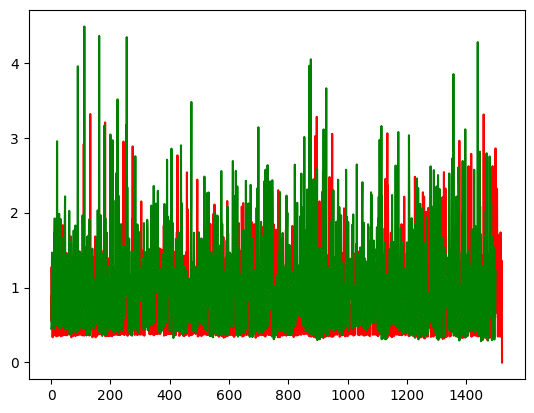

In [274]:
plt.plot(test_hwk_sys.residual_hist[0], color = "red")
plt.plot(test_hwk_sys.one_step_res[0], color = "green")

In [ ]:
test_hwk_sys_2 = hawkes_system()
test_hwk_sys_2.theta = .01
# test_hwk_sys_2.a  = test_hwk_sys_2.a * np.random.rand(3, 3)*2
# test_hwk_sys_2.mu = (test_hwk_sys_2.mu * np.random.rand(1,3) * 3)[0]
tq_2 = deque()

for i in range(3600 * 1): 
    row_test = test_df.loc[[50+ i], :] 
    test_hwk_sys_2.read_pd_raw(row_curr=row_test)
    output = test_hwk_sys_2.get_state_outputs()
    tq_2.append(output)
    # print(output)


not enough terms to define a state
not enough variables to update state
not enough variables to update state
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY
YAYY


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

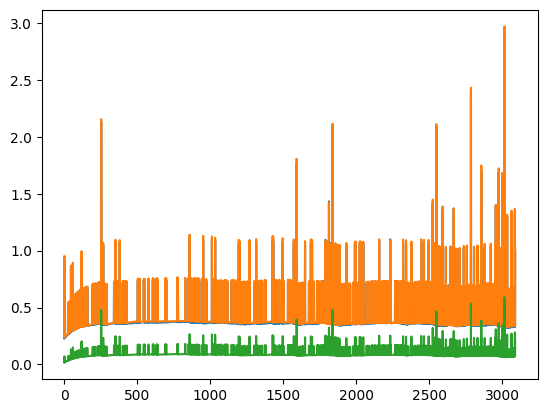

In [570]:
plt.plot(test_hwk_sys_2.dLambda_hist)

In [572]:
np.mean(test_hwk_sys_2.dLambda_hist, axis =0)

array([0.41817168, 0.42571339, 0.09438323])

### Some Quick Experiments

In [564]:
test_mvh = MVH()
mu =  np.array([0.1, 0.1])
A=  np.array([[0.1, 0.02],[0.02, 0.1]])
theta = .01 
test_mvh.set_params(mu = mu,A=A, theta = theta  )

t, c = test_mvh.sample(100000)

num_parms = len(mu)

In [565]:
S = get_states(num_states =num_parms, theta = theta, t_val =t, c_val = c)
compensator = get_compensator_increments(mu = mu, A = A , t_val = t , state_machine= S)
Lam_0 = compensator[0]


In [579]:

w = 30
res_sum = np.convolve(Lam_0, np.ones(w), mode='valid')
delta = w / res_sum
Lam_0_corr = Lam_0[w-1:] * delta

In [577]:
import scipy.stats as st

stat, pval = st.kstest(Lam_0_corr, 'expon', args=(0,1))
print(f"KS test after correction: stat={stat:.3f}, p={pval:.3f}")

stat, pval = st.kstest(Lam_0, 'expon', args=(0,1))
print(f"KS test before correction: stat={stat:.3f}, p={pval:.3f}")


KS test after correction: stat=0.170, p=0.000
KS test before correction: stat=0.237, p=0.000


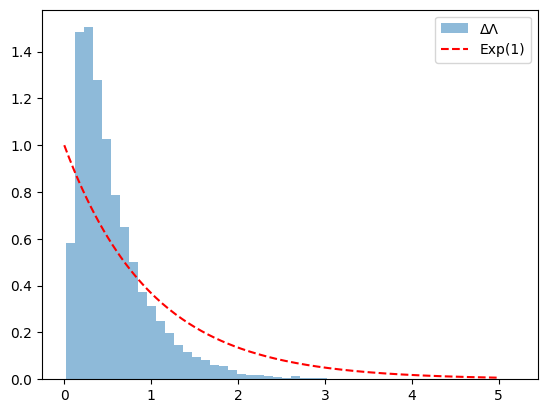

In [574]:

plt.hist(Lam_0, bins=50, density=True, alpha=0.5, label='ΔΛ')
x = np.linspace(0, 5, 200)
plt.plot(x, st.expon.pdf(x), 'r--', label='Exp(1)')
plt.legend(); plt.show()


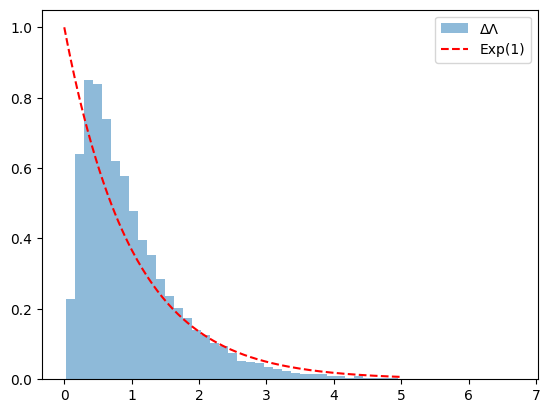

In [580]:

plt.hist(Lam_0_corr, bins=50, density=True, alpha=0.5, label='ΔΛ')
x = np.linspace(0, 5, 200)
plt.plot(x, st.expon.pdf(x), 'r--', label='Exp(1)')
plt.legend(); plt.show()
